- `match_id`: 比赛的唯一标识符。
- `player1` 和 `player2`: 参与比赛的两位选手的名字。
- `elapsed_time`: 从比赛开始到当前点的经过的时间。
- `set_no`: 当前的比赛局数。
- `game_no`: 当前的比赛场数。
- `point_no`: 当前的比赛分数。
- `p1_sets` 和 `p2_sets`: 选手1和选手2赢得的比赛局数。
- `p1_games` 和 `p2_games`: 选手1和选手2赢得的比赛场数。
- `p1_points` 和 `p2_points`: 选手1和选手2赢得的比赛分数。
- `p1_break_pt_missed` 和 `p2_break_pt_missed`: 选手1和选手2错过的破发点。
- `p1_distance_run` 和 `p2_distance_run`: 选手1和选手2在比赛中跑过的距离。
- `rally_count`: 一次交换球的次数。
- `speed_mph`: 发球的速度，单位是英里每小时。
- `serve_width`: 发球的宽度。
- `serve_depth`: 发球的深度。
- `return_depth`: 返回球的深度。
- `Net-cnt`: 上网的次数。
- `Net-sc-rate`: 上网成功的比率。


In [1]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv('Wimbledon_featured_matches.csv')

# 删除含有缺失值的行
df = df.dropna()

# 将修改后的 DataFrame 保存回 CSV 文件
df.to_csv('Wimbledon_featured_matches.csv')


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
df=pd.read_csv('Wimbledon_featured_matches.csv')
p1 = 0
p2 = 0
gameno = 1
index = -1

tot_break_game = 0
short_break_game = 0
pre_break_game = []

tot_hold_game = 0
short_hold_game = 0
pre_hold_game = []

match_t = 1
set_no = 1

tot_game_cnt = 0

tot_net_cnt = 0
tot_net_won = 0
tot_game_unf_err = 0

short_break_game1 = 0
short_hold_game1 = 0
tot_break_game1 = 0
tot_hold_game1 = 0
pre_break_game1 = []
pre_hold_game1 = []
tot_net_cnt1 = 0
tot_net_won1 = 0
tot_game_unf_err1 = 0
# df[1,'SD'] = 100
for t,row in df.iterrows():
    t = int(t)
    # print(t)
    # ------------------初始化计数器-----------------------------------------
    if gameno != int(row['game_no']):   #   换了一个game
        p1 = 0
        p2 = 0
        gameno = int(row['game_no'])
        tot_game_unf_err = 0
    if row['set_no'] == 1 and set_no != 1:  #   换了一个match
        set_no = 1
        # match_t = t
        tot_break_game = 0
        short_break_game = 0
        pre_break_game = []

        tot_hold_game = 0
        short_hold_game = 0
        pre_hold_game = []

        tot_game_cnt = 0
        tot_net_cnt = 0
        tot_net_won = 0
        
    # ------------------预处理得分情况 P1S P2S 本场game的得分领先进度 SGA-----------------------------------------
    win_no = int(row['point_victor'])
    p1 = p1 + (win_no == 1)
    p2 = p2 + (win_no == 2)
    df.loc[t, 'P1S'] = int(p1)
    df.loc[t, 'P2S'] = int(p2)
    df.loc[t,'SGA']= p1-p2
    
    df.loc[t,'SGA1'] = p2 - p1
    
    #----------计算奔跑回报率 = 奔跑距离*(是否得分 + log2(1 + 2*分数比))/(1 + 奔跑距离)----------
    run = row['p1_distance_run']
    score_rate = 0
    if p2 != 0:
        score_rate =  p1/p2
    run_rate = run * ((row['point_victor'] == 1) +  math.log2(1 + 2 * score_rate ))/ (1 + run)
    df.loc[t,'RE'] = run_rate 
    
    if p1 != 0:
        score_rate =  p2/p1
    run_rate = run * ((row['point_victor'] == 2) +  math.log2(1 + 2 * score_rate ))/ (1 + run)
    df.loc[t,'RE1'] = run_rate
    
    #----------计算非强迫性失误----------------------------------------------------------------------
    if row['p1_unf_err'] == 1:
        tot_game_unf_err -= 1
    df.loc[t,'Unf_err_cnt'] =  tot_game_unf_err
    
    if row['p2_unf_err'] == 1:
        tot_game_unf_err1 -= 1
    df.loc[t,'Unf_err_cnt1'] =  tot_game_unf_err1

    # ------------------预处理短期破球数等 STB LTB STH LTH-----------------------------------------
    df.loc[t,'STB'] = short_break_game
    df.loc[t,'LTB'] = tot_break_game
    df.loc[t,'STH'] = short_hold_game
    df.loc[t,'LTH'] = tot_hold_game
    
    df.loc[t,'STB1'] = short_break_game1
    df.loc[t,'LTB1'] = tot_break_game1
    df.loc[t,'STH1'] = short_hold_game1
    df.loc[t,'LTH1'] = tot_hold_game1
    
    tot_game_cnt += 1
    set_no = row['set_no']

    if row['p1_break_pt_won'] == 1:#    p1破发
        tot_break_game += 1
        short_break_game += 1
        pre_break_game.append(tot_game_cnt)

    elif row['game_victor'] == 1 and row['server'] == 1:#     p1保发
        tot_hold_game += 1
        short_hold_game += 1
        pre_hold_game.append(tot_game_cnt)

    for index, value in enumerate(pre_break_game):
        if (tot_game_cnt - 5 == value and value > 0):
            pre_break_game[index] = -1
            short_break_game -= 1

    for index, value in enumerate(pre_hold_game):
        if (tot_game_cnt - 5 == value and value > 0):
            pre_hold_game[index] = -1
            short_hold_game -= 1

    if row['p2_break_pt_won'] == 1:#    p2破发
        tot_break_game1 += 1
        short_break_game1 += 1
        pre_break_game1.append(tot_game_cnt)
    
    elif row['game_victor'] == 2 and row['server'] == 2:#     p2保发
        tot_hold_game1 += 1
        short_hold_game1 += 1
        pre_hold_game1.append(tot_game_cnt)
        
    for index, value in enumerate(pre_break_game1):
        if (tot_game_cnt - 5 == value and value > 0):
            pre_break_game1[index] = -1
            short_break_game1 -= 1
            
    for index, value in enumerate(pre_hold_game1):
        if (tot_game_cnt - 5 == value and value > 0):
            pre_hold_game1[index] = -1
            short_hold_game1 -= 1
    
    df.loc[t,'STB'] = short_break_game
    df.loc[t,'LTB'] = tot_break_game
    df.loc[t,'STH'] = short_hold_game
    df.loc[t,'LTH'] = tot_hold_game
    
    df.loc[t,'STB1'] = short_break_game1
    df.loc[t,'LTB1'] = tot_break_game1
    df.loc[t,'STH1'] = short_hold_game1
    df.loc[t,'LTH1'] = tot_hold_game1

    #------------------上网次数 Net-cnt-----------------------------------------

    if row['p1_net_pt'] == 1:
        tot_net_cnt +=1
    if row['p1_net_pt_won'] == 1:
        tot_net_won +=1

    if row['p2_net_pt'] == 1:
        tot_net_cnt1 +=1
    if row['p2_net_pt_won'] == 1:
        tot_net_won1 +=1
    
    df.loc[t,'Net-cnt'] = tot_net_cnt
    if tot_net_cnt != 0:
        df.loc[t,'Net-sc-rate'] = tot_net_won / tot_net_cnt
    else:
        df.loc[t,'Net-sc-rate'] = 0
        
    df.loc[t,'Net-cnt1'] = tot_net_cnt1
    if tot_net_cnt1 != 0:
        df.loc[t,'Net-sc-rate1'] = tot_net_won1 / tot_net_cnt1
    else:
        df.loc[t,'Net-sc-rate1'] = 0
    #------------------是否是发球方 BTS-----------------------------------------
    # print(row['server'] == 1)
    df.loc[t,'BTS']=int(row['server'] == 1)
    
    df.loc[t,'BTS1']=int(row['server'] == 2)
    #------------------# 发球深度 SD-----------------------------------------
    if row['serve_depth'] == 'NCTL':
        df.loc[t,'SD'] = 3.5
    elif row['serve_depth'] == 'CTL':
        df.loc[t,'SD'] = 2
        
    df.loc[t,'SD1'] = 3.5 if row['serve_depth'] == 'CTL' else 2
    #------------------# 发球深度 SW----------------------------------------
    if row['serve_width'] == 'B'or row['serve_width'] == 'C':
        df.loc[t,'SW'] = 0
    elif row['serve_width'] == 'BC':
        df.loc[t,'SW'] = 7.8
    elif row['serve_width'] == 'BW':
        df.loc[t,'SW'] = 23.4
    elif row['serve_width'] == 'W':
        df.loc[t,'SW'] = 31.2

    if row['serve_width'] == 'B'or row['serve_width'] == 'C':
        df.loc[t,'SW1'] = 0
    elif row['serve_width'] == 'BC':
        df.loc[t,'SW1'] = 7.8
    elif row['serve_width'] == 'BW':
        df.loc[t,'SW1'] = 23.4
    elif row['serve_width'] == 'W':
        df.loc[t,'SW1'] = 31.2
    
df.to_csv('final.csv')

In [9]:
from sklearn.preprocessing import MinMaxScaler
# ------------------------------------------数据归一化---------------------------------------
import os
df=pd.read_csv('final.csv',index_col=0)
# 选择归一化的列
columns_to_normalize = ['speed_mph', 'SD', 'SW', 'STB', 'LTB', 'STH', 'LTH', 'Net-cnt', 'Net-sc-rate', 'RE', 'Unf_err_cnt', 'BTS', 'p1_games', 'SGA', 'P1S', 'P2S', 'RE1', 'Unf_err_cnt1', 'STB1', 'LTB1', 'STH1', 'LTH1', 'Net-cnt1', 'Net-sc-rate1', 'BTS1', 'SD1', 'SW1','p2_games','SGA1']

# 创建归一化器
scaler = MinMaxScaler()

# 对选定的列进行归一化
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# 保存特定的列到新的 CSV 文件
df[columns_to_normalize].to_csv('check.csv', index=False)
unique_match_ids = df['match_id'].unique()

for match_id in unique_match_ids:
    # 选择 match_id 对应的行
    df_match = df[df['match_id'] == match_id]
    
    # 将这些行保存到一个单独的 CSV 文件中
    df_match.to_csv(f'match_{match_id}.csv', index=False)
for match_id in unique_match_ids:
    df=pd.read_csv(f'match_{match_id}.csv')
    df['p1_momentum'] = 0
    df['p2_momentum'] = 0
    p1_momentum = 0
    first_weights = [0.46729598, 0.27718059, 0.16008848,0.9543495]
    secondary_weights = pd.DataFrame({
        '发球技术': {'speed_mph': 0.059669, 'SD': 0.308803, 'SW': 0.631528},
        '比赛表现': {'STB': 0.562794, 'LTB': 0.150671, 'STH': 0.231194, 'LTH': 0.055341},
        '个人技术表现': {'Net-cnt': 0.319694, 'Net-sc-rate': 0.125090, 'RE': 0.548508, 'Unf_err_cnt': 0.006708},
        '比赛局势': {'BTS': 0.654883, 'p1_games': 0.295528, 'SGA': 0.049589}
    })
    # 遍历数据，计算动量
    for i in range(len(df)):
        speed_mph = df.loc[i, 'speed_mph']  
        SD = df.loc[i, 'SD']
        SW = df.loc[i, 'SW']
        STB = df.loc[i, 'STB']
        LTB = df.loc[i, 'LTB']
        STH = df.loc[i, 'STH']
        LTH = df.loc[i, 'LTH']
        Net_cnt = df.loc[i, 'Net-cnt']
        Net_sc_rate = df.loc[i, 'Net-sc-rate']
        RE = df.loc[i, 'RE']
        Unf_err_cnt = df.loc[i, 'Unf_err_cnt']
        BTS = df.loc[i, 'BTS']
        p1_games = df.loc[i, 'p1_games']
        SGA = df.loc[i, 'SGA']
    
        SD1 = df.loc[i, 'SD1']
        SW1 = df.loc[i, 'SW1']
        STB1 = df.loc[i, 'STB1']
        LTB1 = df.loc[i, 'LTB1']
        STH1 = df.loc[i, 'STH1']
        LTH1 = df.loc[i, 'LTH1']
        Net_cnt1 = df.loc[i, 'Net-cnt1']
        Net_sc_rate1 = df.loc[i, 'Net-sc-rate1']
        RE1 = df.loc[i, 'RE1']
        Unf_err_cnt1 = df.loc[i, 'Unf_err_cnt1']
        BTS1 = df.loc[i, 'BTS1']
        p1_games1 = df.loc[i, 'p2_games']
        SGA1 = df.loc[i, 'SGA1']
        # 根据发球方调整动量
        p1_momentum = speed_mph * first_weights[0] * secondary_weights['发球技术']['speed_mph'] + SD * first_weights[0] * secondary_weights['发球技术']['SD'] + SW * first_weights[0] * secondary_weights['发球技术']['SW'] \
            + STB * first_weights[1] * secondary_weights['比赛表现']['STB'] + LTB * first_weights[1] * secondary_weights['比赛表现']['LTB'] + STH * first_weights[1] * secondary_weights['比赛表现']['STH'] + LTH * first_weights[1] * secondary_weights['比赛表现']['LTH'] \
                + Net_cnt * first_weights[2] * secondary_weights['个人技术表现']['Net-cnt'] + Net_sc_rate * first_weights[2] * secondary_weights['个人技术表现']['Net-sc-rate'] + RE * first_weights[2] * secondary_weights['个人技术表现']['RE'] + Unf_err_cnt * first_weights[2] * secondary_weights['个人技术表现']['Unf_err_cnt'] \
                    + BTS * first_weights[3] * secondary_weights['比赛局势']['BTS'] + p1_games * first_weights[3] * secondary_weights['比赛局势']['p1_games'] + SGA * first_weights[3] * secondary_weights['比赛局势']['SGA'] 

        p2_momentum = speed_mph * first_weights[0] * secondary_weights['发球技术']['speed_mph'] + SD * first_weights[0] * secondary_weights['发球技术']['SD'] + SW * first_weights[0] * secondary_weights['发球技术']['SW'] \
            + STB1 * first_weights[1] * secondary_weights['比赛表现']['STB'] + LTB1 * first_weights[1] * secondary_weights['比赛表现']['LTB'] + STH1 * first_weights[1] * secondary_weights['比赛表现']['STH'] + LTH1 * first_weights[1] * secondary_weights['比赛表现']['LTH'] \
                + Net_cnt1 * first_weights[2] * secondary_weights['个人技术表现']['Net-cnt'] + Net_sc_rate1 * first_weights[2] * secondary_weights['个人技术表现']['Net-sc-rate'] + RE1 * first_weights[2] * secondary_weights['个人技术表现']['RE'] + Unf_err_cnt1 * first_weights[2] * secondary_weights['个人技术表现']['Unf_err_cnt'] \
                    + BTS1 * first_weights[3] * secondary_weights['比赛局势']['BTS'] + p1_games1 * first_weights[3] * secondary_weights['比赛局势']['p1_games'] + SGA1 * first_weights[3] * secondary_weights['比赛局势']['SGA']

        # 考虑场上比分

        df.loc[i, 'p1_momentum'] += p1_momentum
        df.loc[i, 'p2_momentum'] += p2_momentum
        df.to_csv(f'match_final_{match_id}.csv')

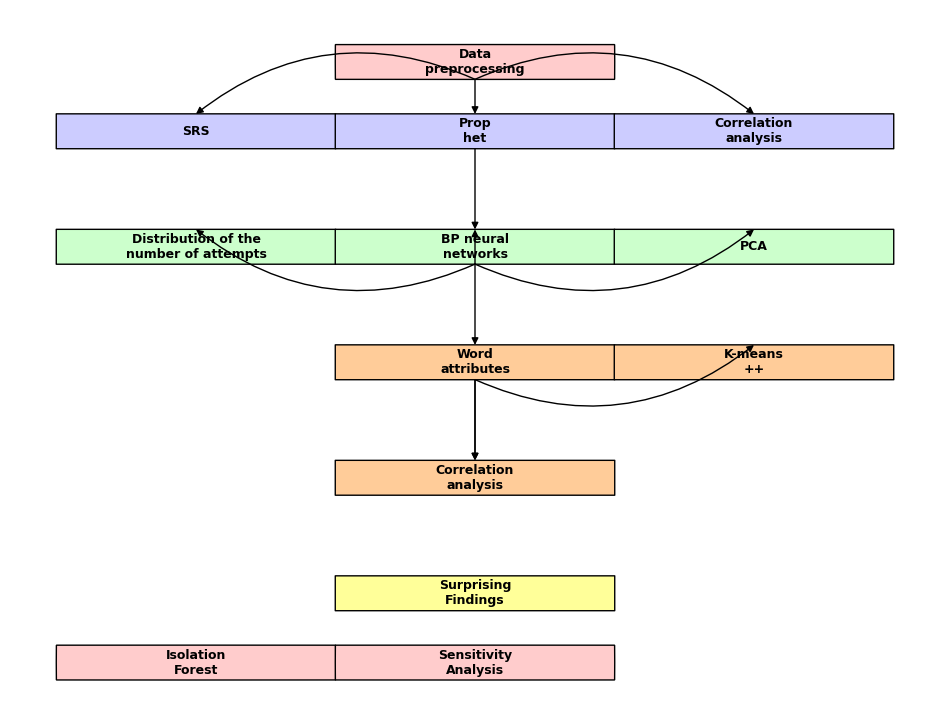

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch

# Define a function to create a box
def create_box(ax, text, xy, color, boxstyle):
    box = FancyBboxPatch((xy[0], xy[1]), 120, 30, boxstyle=boxstyle, ec="black", fc=color, lw=1)
    ax.add_patch(box)
    ax.text(xy[0]+60, xy[1]+15, text, ha='center', va='center', fontsize=9, color='black', weight='bold')

# Define a function to connect boxes
def connect_boxes(ax, xyA, xyB, color, connectionstyle):
    con = ConnectionPatch(xyA=(xyA[0]+60, xyA[1]+15), xyB=(xyB[0]+60, xyB[1]+15), coordsA='data', coordsB='data',
                          axesA=ax, axesB=ax, arrowstyle="-|>", connectionstyle=connectionstyle, color=color, lw=1)
    ax.add_patch(con)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(0, 400)
ax.set_ylim(0, 600)
ax.axis('off')

# Define the colors and box styles
colors = ['#FFCCCC', '#CCCCFF', '#CCFFCC', '#FFCC99', '#FFFF99']
boxstyles = ["round4,pad=0.1", "round,pad=0.1", "round,pad=0.1", "round,pad=0.1", "round,pad=0.1"]

# Step 1
create_box(ax, "Data\npreprocessing", (140, 540), colors[0], boxstyles[0])
create_box(ax, "SRS", (20, 480), colors[1], boxstyles[1])
create_box(ax, "Prop\nhet", (140, 480), colors[1], boxstyles[1])
create_box(ax, "Correlation\nanalysis", (260, 480), colors[1], boxstyles[1])

# Step 2
create_box(ax, "Distribution of the\nnumber of attempts", (20, 380), colors[2], boxstyles[2])
create_box(ax, "BP neural\nnetworks", (140, 380), colors[2], boxstyles[2])
create_box(ax, "PCA", (260, 380), colors[2], boxstyles[2])

# Step 3
create_box(ax, "Word\nattributes", (140, 280), colors[3], boxstyles[3])
create_box(ax, "K-means\n++", (260, 280), colors[3], boxstyles[3])
create_box(ax, "Correlation\nanalysis", (140, 180), colors[3], boxstyles[3])

# Step 4
create_box(ax, "Surprising\nFindings", (140, 80), colors[4], boxstyles[4])
create_box(ax, "Isolation\nForest", (20, 20), colors[0], boxstyles[0])
create_box(ax, "Sensitivity\nAnalysis", (140, 20), colors[0], boxstyles[0])

# Connect boxes within steps
connect_boxes(ax, (140, 525), (20, 495), 'black', "arc3,rad=0.3")
connect_boxes(ax, (140, 525), (140, 495), 'black', "arc3,rad=0")
connect_boxes(ax, (140, 525), (260, 495), 'black', "arc3,rad=-0.3")

connect_boxes(ax, (140, 365), (20, 395), 'black', "arc3,rad=-0.3")
connect_boxes(ax, (140, 365), (140, 395), 'black', "arc3,rad=0")
connect_boxes(ax, (140, 365), (260, 395), 'black', "arc3,rad=0.3")

connect_boxes(ax, (140, 265), (140, 195), 'black', "arc3,rad=0")
connect_boxes(ax, (140, 265), (260, 295), 'black', "arc3,rad=0.3")

# Connect boxes across steps
connect_boxes(ax, (140, 465), (140, 395), 'black', "arc3,rad=0")
connect_boxes(ax, (140, 365), (140, 295), 'black', "arc3,rad=0")
connect_boxes(ax, (140, 265), (140, 195), 'black', "arc3,rad=0")




|              | 发球技术 | 比赛表现 | 个人技术表现 | 比赛局势 |
|--------------|----------|----------|--------------|----------|
| 发球技术      | 1        | 2        | 3            | 4        |
| 比赛表现      | 1/2      | 1        | 2            | 3        |
| 个人技术表现  | 1/3      | 1/2      | 1            | 2        |
| 比赛局势      | 1/4      | 1/3      | 1/2          | 1        |


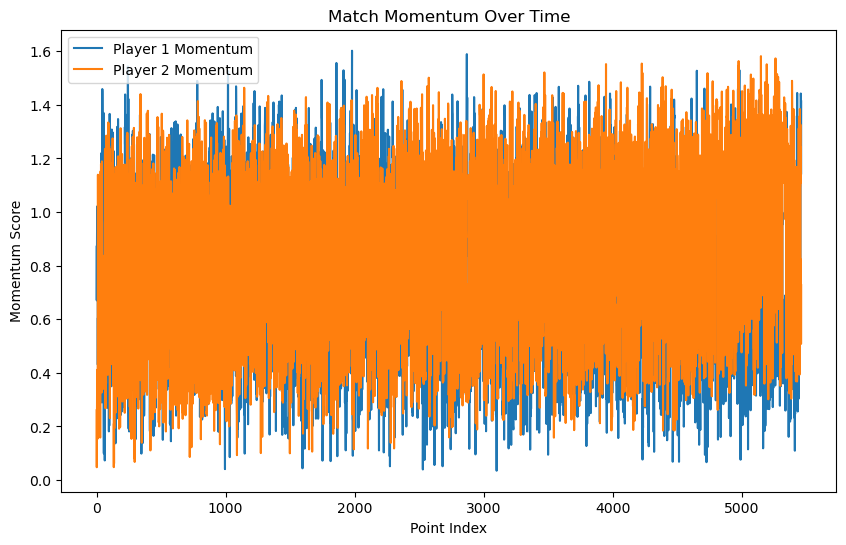

In [41]:
import matplotlib.pyplot as plt

df=pd.read_csv('check.csv')
df['p1_momentum'] = 0
df['p2_momentum'] = 0
p1_momentum = 0
first_weights = [0.46729598, 0.27718059, 0.16008848,0.9543495]
secondary_weights = pd.DataFrame({
    '发球技术': {'speed_mph': 0.059669, 'SD': 0.308803, 'SW': 0.631528},
    '比赛表现': {'STB': 0.562794, 'LTB': 0.150671, 'STH': 0.231194, 'LTH': 0.055341},
    '个人技术表现': {'Net-cnt': 0.319694, 'Net-sc-rate': 0.125090, 'RE': 0.548508, 'Unf_err_cnt': 0.006708},
    '比赛局势': {'BTS': 0.654883, 'p1_games': 0.295528, 'SGA': 0.049589}
})
# 遍历数据，计算动量
for i in range(len(df)):
    speed_mph = df.loc[i, 'speed_mph']
    SD = df.loc[i, 'SD']
    SW = df.loc[i, 'SW']
    STB = df.loc[i, 'STB']
    LTB = df.loc[i, 'LTB']
    STH = df.loc[i, 'STH']
    LTH = df.loc[i, 'LTH']
    Net_cnt = df.loc[i, 'Net-cnt']
    Net_sc_rate = df.loc[i, 'Net-sc-rate']
    RE = df.loc[i, 'RE']
    Unf_err_cnt = df.loc[i, 'Unf_err_cnt']
    BTS = df.loc[i, 'BTS']
    p1_games = df.loc[i, 'p1_games']
    SGA = df.loc[i, 'SGA']
    
    SD1 = df.loc[i, 'SD1']
    SW1 = df.loc[i, 'SW1']
    STB1 = df.loc[i, 'STB1']
    LTB1 = df.loc[i, 'LTB1']
    STH1 = df.loc[i, 'STH1']
    LTH1 = df.loc[i, 'LTH1']
    Net_cnt1 = df.loc[i, 'Net-cnt1']
    Net_sc_rate1 = df.loc[i, 'Net-sc-rate1']
    RE1 = df.loc[i, 'RE1']
    Unf_err_cnt1 = df.loc[i, 'Unf_err_cnt1']
    BTS1 = df.loc[i, 'BTS1']
    p1_games1 = df.loc[i, 'p2_games']
    SGA1 = df.loc[i, 'SGA1']
    # 根据发球方调整动量
    p1_momentum = speed_mph * first_weights[0] * secondary_weights['发球技术']['speed_mph'] + SD * first_weights[0] * secondary_weights['发球技术']['SD'] + SW * first_weights[0] * secondary_weights['发球技术']['SW'] \
        + STB * first_weights[1] * secondary_weights['比赛表现']['STB'] + LTB * first_weights[1] * secondary_weights['比赛表现']['LTB'] + STH * first_weights[1] * secondary_weights['比赛表现']['STH'] + LTH * first_weights[1] * secondary_weights['比赛表现']['LTH'] \
            + Net_cnt * first_weights[2] * secondary_weights['个人技术表现']['Net-cnt'] + Net_sc_rate * first_weights[2] * secondary_weights['个人技术表现']['Net-sc-rate'] + RE * first_weights[2] * secondary_weights['个人技术表现']['RE'] + Unf_err_cnt * first_weights[2] * secondary_weights['个人技术表现']['Unf_err_cnt'] \
                + BTS * first_weights[3] * secondary_weights['比赛局势']['BTS'] + p1_games * first_weights[3] * secondary_weights['比赛局势']['p1_games'] + SGA * first_weights[3] * secondary_weights['比赛局势']['SGA'] 
    
    p2_momentum = speed_mph * first_weights[0] * secondary_weights['发球技术']['speed_mph'] + SD * first_weights[0] * secondary_weights['发球技术']['SD'] + SW * first_weights[0] * secondary_weights['发球技术']['SW'] \
        + STB1 * first_weights[1] * secondary_weights['比赛表现']['STB'] + LTB1 * first_weights[1] * secondary_weights['比赛表现']['LTB'] + STH1 * first_weights[1] * secondary_weights['比赛表现']['STH'] + LTH1 * first_weights[1] * secondary_weights['比赛表现']['LTH'] \
            + Net_cnt1 * first_weights[2] * secondary_weights['个人技术表现']['Net-cnt'] + Net_sc_rate1 * first_weights[2] * secondary_weights['个人技术表现']['Net-sc-rate'] + RE1 * first_weights[2] * secondary_weights['个人技术表现']['RE'] + Unf_err_cnt1 * first_weights[2] * secondary_weights['个人技术表现']['Unf_err_cnt'] \
                + BTS1 * first_weights[3] * secondary_weights['比赛局势']['BTS'] + p1_games1 * first_weights[3] * secondary_weights['比赛局势']['p1_games'] + SGA1 * first_weights[3] * secondary_weights['比赛局势']['SGA']
                  
    # 考虑场上比分

    df.loc[i, 'p1_momentum'] += p1_momentum
    df.loc[i, 'p2_momentum'] += p2_momentum
    df.to_csv('new_data_final_final.csv')
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['p1_momentum'], label='Player 1 Momentum')
plt.plot(df.index, df['p2_momentum'], label='Player 2 Momentum')
plt.title('Match Momentum Over Time')
plt.xlabel('Point Index')
plt.ylabel('Momentum Score')
plt.legend()
plt.show()

In [44]:
import pandas as pd
from scipy.stats import norm

# Since the image to text conversion capability is not available,
# we will assume the data from the image has been manually transcribed into a list for further analysis.
# Here's the hypothetical list of momentum values obtained from the image:

# 读取 CSV 文件
data = pd.read_csv('new_data_final_final.csv')

# 从 "p1_momentum" 列中获取 "momentum_values"
momentum_values = data['p1_momentum']

# Convert the momentum values into binary sequence based on whether they are above or below the median.
median_value = pd.Series(momentum_values).median()

# Define a binary sequence where 1 indicates the value is above or equal to the median, and 0 otherwise.
binary_sequence = [1 if value >= median_value else 0 for value in momentum_values]

# Count the number of runs (a run is a sequence of increasing or decreasing values)
runs = 0
n1 = binary_sequence.count(1)
n2 = binary_sequence.count(0)

# A helper function to count runs
def count_runs(seq):
    runs = 1 # Start with 1 because the first value itself is a run.
    for i in range(1, len(seq)):
        # Increment run count each time there is a change from 0 to 1 or 1 to 0.
        if seq[i] != seq[i-1]:
            runs += 1
    return runs

runs = count_runs(binary_sequence)

# Calculate the expected number of runs (E[R]) and the variance of the number of runs (Var[R])
E_R = ((2 * n1 * n2) / (n1 + n2)) + 1
Var_R = ((2 * n1 * n2) * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2)**2 * (n1 + n2 - 1))

# Calculate the test statistic Z
Z = (runs - E_R) / (Var_R ** 0.5)

# Calculate the p-value from the Z-score
p_value = norm.sf(abs(Z)) * 2  # Two-tailed test

# runs, n1, n2, E_R, Var_R, Z, p_value
print("{:.10f}".format(p_value))



0.0000000000
